# Chapter 3:  De-Novo Genome Assembly (基因组从头拼接)
___

## Outline

In this lecture, we will cover the fundamental concepts as well as the popular algorithms applied in de-novo genome assembly in next-generation sequencing (NGS):

- [The Genome Assembly and the related concepts](#1.-Genome-assembly:-The-concepts)

- [The Overlaps and Overlap graphs of the reads](#2.-Overlaps)

- [The SCS approaches](#3.-The-Simplest-approach:-Shortest-common-superstring)

- [The OLC approach](#4.1-OLC-approach)

- [The De-Bruijn Graph Algorithm](#4.2-De-Bruijn-Graph-Algorithm)

And we need to finish the following exercises:
- [EXERCISE 1](#$\S$-EXERCISE-1)
- [EXERCISE 2](#$\S$-EXERCISE-2)
- [EXERCISE 3](#$\S$-EXERCISE-3)

## 1. Genome assembly: The concepts

Whole-genome "shotgun" sequencing starts by amplifying and fragmenting the genome DNA. Here **shotgun** refers to the **random fragmentation** of the whole genome sequence, as if it was fired from a gun.

![](../images/shotgun.png)

Now the novel sequencing technologies of long read up to 1000 bases become available, which makes it easier of the  assembly task. But here we will focus on the short reads assemly which generated by comtemporary sequencing instruments, which is, the **second-generation sequencing**, while the former is known as the **third-generation sequencing**.

So now we have in hands the fragmented reads and the notion is that we know that they're going to align them up like a puzzle.

In next-generation sequencing, almost all genome positions are **covered** by many reads. The assembly task will be to reconstruct the genome from these short reads.  But the number of reads is perhaps 200 million or even a billion. And thus it's quite a touch task to put a huge number of pieces together if we don't really know where they are coming from.  Because we don't have the genome (reference) to guide us.

That's called the **de-novo assembly**, starting from the scratch. You are given a set of reads for your organism of interest, and we're going to assemble it into contigs or even scaffolds today.

This approach is quite different from the so-called **reference-guided assembly**, which is a model-based assembly. Whereas de-novo assembly is an non-model approach. For guided assembly, you can map the reads back to the reference genome, so it's pretty easier.

However, as you can tell, there is a large structural variation between the reference genome and the resequencing genomes, that process might fail.

So today we'll focus upon **De-Novo Genome Assembly**.

### 1.1 Key term: Coverage

Usually the **coverage** is short for the **mean coverage**, which is the average number of reads covering a position in the genome.

Assume that the genome size is $G$, and the read length is $R$. If we have N reads, then the coverage  can be computed as
$$
\text{coverage} = \frac{N \times R}{G}
$$

So if $N= 11$, $R=17$ and $G=35$, then the coverage should be $\frac{17 \times 11}{35} \approx 5.3$.

### 1.2 Estimating Uncovered Bases

This algorithm is proposed by Lander and Waterman.

As we shown before, the coverage 
$$
\lambda = \frac{NR}{G} = \frac{\text{length of all reads}}{\text{length of genome}}
$$

Therefore, the probability that a base  is not covered can be approximated using a Poisson distribution:
$$
Poisson(0, \lambda) \approx e^{-\lambda}
$$

Thus the number of uncovered bases should be
$$
u \approx G e^{-\lambda}
$$

And the nuber of gaps:
$$
g \approx Ne^{-\lambda}
$$

But unfortunately, the Poisson approximation is not a good fit for the real data, since the library is biased. Therefore, we might use the other approximation techniques like negative Binomial approximation.

Coverage could also refer to the number of reads covering a particular position in the genome.

### <font color="red">$\S$ EXERCISE 1</font>

Can you write a python program, to compute the per-base coverage for a set of reads and also the `*.sai` files generated by the alignment software `bwa` against the corresponding reference genome.

### 1.3 Sequencing error

Say two reads truly originate from overlapping stretches of the genome. Why might there be differences? There are two possible reasons:

- The first reason is that there is an error in either of the reads. So quality score can help us decide which is the truth.
- The second is due to the difference between inherited copies of a chromosome, from paternal or maternal parent. We know that human are diploid. And these two copies can differ.


We can call them allelic difference, which will pop up in terms of non-concordance of our reads. But remember for human and the other organisms, the reference genome is haploid.


## 2. Overlaps

Overlaps are essential for genome assembly. WE CANNOT REBUILD THE GENOME UNLESS THERE ARE OVERLAPS BETWEEN THE SEQUENCED READS.

Finding all overlaps is like building a **directed graph** where directed edges connect overlapping nodes (reads) where the *suffix of sources is similar to the prefix of sink*.

### 2.1 Directed graph review

Directed graph $G(V, E)$ consists of set of *vetices*, $V$ and set of *directed edges*, $E$.

Directed edge is an *ordered pair of vertices* with first the **source** and second the **sink**.

In a typical graph, the vertices (a.k.a node) are drawn as circles, while the edges (a.k.a arcs) are drawn as lines with an arrow connecting two circles.

Directed graphs are also called *digraphs*.

### 2.2 How to compute the longest overlap between two reads?

In [22]:
def overlap(a, b, min_length=3):
    """
    Compute the maximum overlap length of suffix of a and prefix of b.
    @PARAMETERS
    -a: string 1
    -b: string 2
    -min_length: the minimum overlap
    @RETURN
    The maximum overlap between a and b
    """
    start = 0
    
    while True:
        start = a.find(b[:min_length], start) # find the match position for b[:min_length] in a[start:]
        if start == -1:
            return 0
        if b.startswith(a[start:]):                          # if perfect match
            return len(a) - start
        start += 1

The function will return the length of the longest overlap between $a$ and $b$. If it is less than `minimum_length`, it will return 0. 

In [23]:
seqa = "ATCGATA"
seqb = "TCGATAC"
overlaps = overlap(seqa, seqb)
print overlaps

6


### 2.3 The overlap graph (重叠图)

In an overlap graph, a vertex is a read; a directed edge is an overlap of at least 3 characters matching between a suffix of the source and the prefix of a sink.

Here is an example:
- Vertices (reads): $\{a: "CTCTAGGCC", b:"GCCCTCAAT", c:"CAATTTTT"\}$
- Edges(overlaps): $\{(a, b), (b, c)\}$

Now let's use the `permutations` function in the module `itertools` to construct the overlap map for a set of reads:

In [24]:
from itertools import permutations
def naive_overlap_map(reads, k):
    """functions to get all the overlaps between two arbitrary reads with overlaps >= k"""
    olaps = {}
    for a, b in permutations(reads, 2):
        s = overlap(a, b, k)
        if s > 0:
            olaps[(a, b)] = s
    return olaps

In [25]:
reads = ["ACGATTACTG","GATTACTGACG","CGATTTACG","CCAGTAG","TGACGGACT"]
maps = naive_overlap_map(reads, k=5)
for key in maps:
    print "{:20}{:20}{:5}".format(key[0],  key[1],  maps[key])

ACGATTACTG          GATTACTGACG             8
GATTACTGACG         TGACGGACT               5


## 3. The Simplest approach: Shortest common superstring

One of the simplest algorithms to assemble the reads is to find the shortest common superstring for these input reads. What is the shortest common superstring (SCS)? 
> **SCS is the shortest string that contains all the input strings as the substrings**.


### 3.1 Brute-force algorithm to find the SCS

How to find the SCS for the input string? One **brute-force approach** is to loop through all the possible combinations (orderings) of the input reads and find the shortest combination:
1. Find all the possible orderings for the input reads using the `itertools.permutations()` function;
2. Compute the length for the superstring;
3. Output the shortest one as the assembly result.

In [26]:
def scs(reads):
    
    shortest_sup = None
    for comb in permutations(reads):
        sup = comb[0]
        for i in xrange(len(reads) - 1):
            olen = overlap(comb[i], comb[i+1], min_length=1)
            sup +=  comb[i+1][olen:]
            
        if shortest_sup is None or len(sup) < len(shortest_sup):
            shortest_sup = sup
            
    return shortest_sup    

In [27]:
print scs(["ACTCAGGACTTACG", "ACTTACGGAGGCT", "GCTACGGACTGGA"])

ACTCAGGACTTACGGAGGCTACGGACTGGA


This brute-force algorithm can absolutely find the optimal solution. However, for a set of $n$ reads, the number of possible combinations is $n!$. When $n$ is large, the huge computational cost is unfeasible and non-practical for our task of assembling the short reads.

### 3.2 Greedy shortest common superstring

Because brute-force approach is not pratical, let's turn to the other method, the greedy SCS, which is much faster than the former approach.

> We call a method greedy, because the algorithm make a series of decison and at each decision point, it will choose the option it will reduce the most the length of the eventual superstring.

This seems like a good strategy. The shorter the superstring, the closer we are to the shortest common substring.

We can visualize the greedy SCS algorithm using an overlap graph. So, let's start with the overlap graph here:
![](../images/greedy.png)

Let's have a look how it works:

1. In each round, find the longest overlap in the remaining overlap graph (that is, pick the edge with the greatest number as its label)

2. Merge the two nodes on either terminal of the edge, and remove the other edges that connect the two nodes as well as the edges pointing to the ingoing node, and also the edges starting from the outgoing node.

3. Iterate the steps (1) and (2), until no nodes can be merged.

4. Stop and output the remaining contigs.

Compared with the previous brute-force approach which tries all possible orderings, the greedy aprpoach greatly reduce the computational cost. And therefore we can see that it is much quicker than the previously mentioned approach.

However, the speed comes at a cost of accuracy. The greedy algorithm is not guaranteed to find the correct answer.
![](../images/greedy-drawbacks.png)

Here is the practical usage of the greedy algorithm.

In [51]:
def pick_longest_overlap(reads, k):
    """Find the longest overlap among a set of reads.
    @PARAMETERS
    -reads: a list of reads
    -k: the threshold of overlap gap length
    @RETURN
    - a tuple containing the start, end and the corresponding longest overlap
    @Note
    -Since there might exists ties, we only pick the first occurrence.
    """
    longest_overlap = 0
    reada, readb = None, None
    for a, b in permutations(reads, 2):
        olen = overlap(a, b, k)
        if olen > longest_overlap:
            longest_overlap = olen
            reada, readb = a, b
    return reada, readb, longest_overlap

And then we iteratively pick the two reads with longest overlap, and merge these two reads, until finally no reads can be merged.

In [52]:
def greedy_scs(reads, k):
    """compute the shortest common superstring from the reads using greedy algorithm.
    @INPUT
    
    @OUTPUT
    
    @NOTE
    """
    read_a, read_b, olen = pick_longest_overlap(reads, k)
    while olen > 0:
        reads.remove(read_a)
        reads.remove(read_b)
        reads.append(read_a + read_b[olen:])
        read_a, read_b, olen = pick_longest_overlap(reads, k)
        
    return "".join(reads)

Here once there is no overlap left in the remaining list of reads, we will return the simple concatenation of the reads using `"".join(reads)`.

In [43]:
myreads = ["AAA","AAB","ABB", "BBA", "BBB"]
print "The shortest common superstring for the input reads %s is %s" % (myreads,  greedy_scs(myreads, 1))

The shortest common superstring for the input reads ['AAA', 'AAB', 'ABB', 'BBA', 'BBB'] is BBBAAABBA


And again, let's try the **brute-force algorithm**:

In [45]:
myreads = ["AAA","AAB","ABB", "BBA", "BBB"]
print "The shortest common superstring for the input reads %s is %s" % (myreads,  scs(myreads))

The shortest common superstring for the input reads ['AAA', 'AAB', 'ABB', 'BBA', 'BBB'] is AAABBBA


**Can you draw a conclusion from the above example and scripts?**

### Take-home message for greedy approach

1. Greedy algorithm is not guaranteed to choose overlaps yielding SCS (shortest common superstring).
2. But greedy algorithm is a good approximation. We do know that there are some bounds of it, i.e. the superstring yielded by the greedy algorithm won't be more than around 2.5 times longer than the true SCS.

That's what a compromise does in finding the shortest common superstring.

### <font color="red">$\S$ EXERCISE 2</font>

In the above implementation, we need to compute the overlaps among the reads once we update the list of reads. This, will unfortunately cause the unnecessary waste of the computational resouces.

Can you fix it?

Hint: Maybe you can store the overlaps into a dictionary, thus what we need to do is to update some of the terms in the dictionary.

### 3.3 How do repeats affect the assembly?

In the previous example, we could find that greedy approach might not reach at the optimal solution. However, when the genome is repetitive, the brute-force approach can also results in a wrong answer.

Here is an example:

In [47]:
genome = "ABAAAAABA"
myreads = ["ABA", "BAA", "AAA", "AAB"]   # the genome can only generate such 3-mers
print scs(myreads)

ABAAAB


#### Over-collapsing issues

We can hardly tell the actual copy number of the repeats (here 'A'), if the read length is short. This is because we can use fewer copies of 'A' to explain the above list of reads (which we call the **over-collapsing problem**), right?

But if the read length is longer, say, 7, which can span the whole repeats section:

In [49]:
myreads2 = ["ABAAAAA", "BAAAAAB", "AAAAABA"]   # the genome can only generate such 3-mers
print scs(myreads2)

ABAAAAABA


Therefore, if the read length is long enough, the repeats will not be an issue. **But how long is long enough?** 

In addition to resulting in fewer copies of repeats, repeats can also result in other serious problems:

In [50]:
genome = "AAABCBAAABBCAAA"
myreads = ["AAA", "AAB", "ABC", "BCB", "CBA", "BAA", "AAB", "ABB", "BCA", "CAA"]
print scs(myreads)

ABCBAAABBCAA


In [52]:
print greedy_scs(myreads, 1)

ABCBAABCAAABB


## 4. Two state-of-the-art approaches to short read assembly

Today we will talk about two general approaches for genome assembly:
<p><img src="../images/assembly.png" height=20% /></p>

### 4.1 OLC approach

- **Overlap Layout Consensus (OLC)** is a kind of string graph assemblers, which works by
    * Construct overlap graph directly from reads;
    * Eliminate redundant reads;
    * Trace path for assembly;
    * Such tools include: SGA, Fermi for longer reads.
    
#### Reference for SGA
* J. Simpson, R. Durbin. Efficient de novo assembly of large genomes using compressed data structures. Genome Res, 2011.

### 4.1.1 Build the overlap graph efficiently

In the early phase, people are afraid of using these type of "OLC" assemblers because of the huge cost of computing overlaps, which was thought to be $\mathcal{O}(n^2)$ where $n$ is the number of reads.

Fortunately, a really clever algorithm was devised that used the technology we have discussed in the previous lecture, the FM-index and Burrows-Wheeler transform that allow us to index a genome and then conduct a lookup of reads in time proportional to the length of the read, $\mathcal{O}(n)$.

Here is essentially the idea. What we are going to do is we're going to take all of the reads to index them all. And we can do that roughly in $\mathcal{O}(n \log n)$ time. And after we index all of the reads, then we can use the index to find overlaps very very efficiently. And you can conceptualize this as simply looking at a read that you have in your hand and looking it up in the index. And you can find all the places the suffix or prefix of that read matches. And you can trace back to find all the places it matches. 

And those all correspond to edges in the graph.

A **merged FM-index** of all reads allows us to match read prefixes and suffixes to discover overlaps.

### 4.1.2 Layout

Now let's turn to how to process an **overlap graph** towards making **contigs**.

The overlap graph is huge and messy, and the contigs will not automatically "pop up" to us. Here is an actual layout-graph, can we dig the contigs out immediately using our eyes? The answer is definitely no. And that comes to the question of layout, which is, how we formulate the problem of tracing a path through an overlap graph.

So the first idea is the shortest common superstring (SCS), as we mentioned earlier in this lecture.

### 4.1.3 Consensus

Since some of the reads contains errors, we need to use the **majorite-vote** mechanism to choose from the possible choice for a *polymorphism*  site.

Furthermore, the input reads may generate **more than one contig**. With further information, we can concatenate these contigs into a scaffold or **scaffolds**.

## 4.2 De-Bruijn Graph Algorithm

Now let's turn to another approach for solving the assembling problem which is based on the De-Bruijn graph.
    
- **de Bruijn graph-based assemblers**, which works by
    * Construct k-mer graph from reads, discarding the original reads;
    * Trace path in graph for assembly.
    * Appropriately for shorter reads.
    * Such tools include: velvet

### 4.2.1 The De-Bruijn graph

Simiar to the overlap graph, the De-Bruijn graph is also a directed graph. The difference is that it is a multigraph, too, which means that there could be multiple edges from a node, $A$, to the other node , $B$. Let's start with an example.

For a genome $G$: <font color="blue">AAABBBBA</font>. And the reads are the substrings of $G$ of length $k$, which we call it the $k$-mer of the genome, $G$.

So the 3-mers of $G$ are: <font color="red">AAA, AAB, BBB, BBB, BBA</font>.

For each $k$-mer, we're going to extract the **left and right $(k-1)$-mers**.
![](../images/debruijn.png)

Now each $(k-1)$-mer will become a node in the graph. And then we add an edge from the left $(k-1)$-mer to the right. 

Now, we can find that
- Each edge represents a $k$-mer, including the identical $k$-mers with more than one occurrence.

- Each node is a distinct $(k-1)$-mer.

Let me ask you a question:
> Can we rebuild the genome only using the above De-Bruijn graph information?

The answer is yes. But how? This is the core for the De-Bruijn graph assembler.

> **The reconstruction of the original genome corresponds to a walk-through of the graph.**

### 4.2.2 Eulerian walk

Start at some node in this De-Bruijn graph, and then move through the graph from node to node, following the edges as we go, respecting the direction of each edge.  And then we can reconstruct the genome as we go.

> ### The walk that allows us to reconstruct the genome, is the walk that crosses each edge exactly once (that is, uses each $k$-mer exactly once).

![](../images/debruijn-walk.png)

This, has a special name,  <font size=3 weight="bold">Eulerian walk</font>.

**But not every De-Bruijn graph can be written as a Eulerian walk.** But if the graph does, we call it a Eulerian graph.

### 4.2.3 The De-Bruijn graph algorithm

- Given the sequenced reads, we construct the corresponding De-Bruijn graph.

- The graph is Eulerian as long as we have one read for every $k$-mer.

- An Eulerian walk-through of the graph will give us a reconstruction of the original genome.

In [6]:
def DeBruijnGaph(st, k):
    """Build the de Bruijn graph based on `k`-mers of `st`.
    """
    nodes = set()
    edges = []
    for i in range(len(st) - k + 1):
        edges.append((st[i:i+k-1], st[i+1:i+k]))    # left and right k-1 mer of the k-mer
        nodes.add(st[i:i+k-1])
        nodes.add(st[i+1:i+k])
    return nodes, edges

In [7]:
genome = "ATCAGGACTGACCACG"
nodes, edges = DeBruijnGraph(genome,  4)
print nodes

set(['ACC', 'ACG', 'ATC', 'AGG', 'CAG', 'CTG', 'GGA', 'ACT', 'CAC', 'GAC', 'TGA', 'CCA', 'TCA'])


And we can visualize the graph like that using graphviz:

In [15]:
def ViewDeBruijnGraph(st, k):
    """Visualize a directed multigraph using graphviz.
    """
    nodes, edges = de_bruijn(st, k)
    dot_str = 'digraph "DeBruijn Graph" {\n'
    for node in nodes:
        dot_str +=  '    %s [label="%s"]   ;\n' %(node, node)
    for src, dest in edges:
        dot_str +=  '    %s -> %s  ;\n' %(src, dest)
    return dot_str  +   '}\n'

In [16]:
%load_ext gvmagic

The gvmagic extension is already loaded. To reload it, use:
  %reload_ext gvmagic


You need to pre-install the `gvmagic` using `pip`.

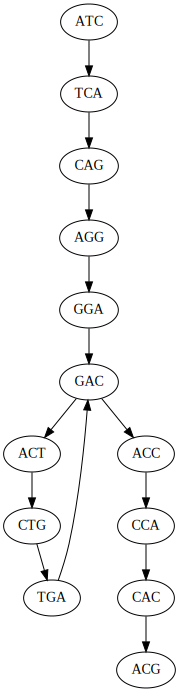

In [18]:
%dotstr ViewDeBruijnGraph(genome, 4)

### 4.2.4 When will Eulerian walk go wrong: The curse of the repetitive genome

In the previous section, we have learned how to build the De-Bruijn graph and how to walk Eulerian to rebuild the original genome. And let's see whether it has resolved the over-collapsing problem of repeats.

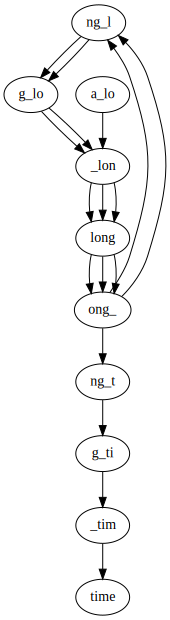

In [19]:
genome = "a_long_long_long_time"
%dotstr view_de_bruijn(genome, 5)

It did NOT over-collapse the repeats `"long_long_long_"`, that is the advatage over SCS-like algorithms. But let's not be too optimistic to think that we have solved all our problems.

Let's see another example:

In [20]:
genome = "ZABCDABEFABY"
k = 3

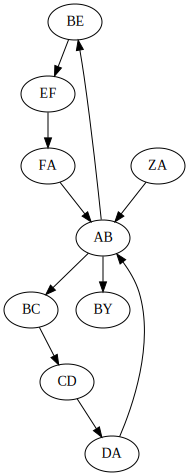

In [21]:
%dotstr view_de_bruijn(genome, k)

In the above De-Bruijn graph, the Eulerian walk is not unique. Thus two possible assembly can be generated like:
- ZAB<font color="blue">CD</font>AB<font color="magenta">EF</font>ABY 

- ZAB<font color="magenta">EF</font>AB<font color="blue">CD</font>ABY

Here the repeats "AB" is not tandem repeats, instead they are anologous the **transposon elements** in the genome. Therefore, you cannot determine whether it is *A* or *B* in the above example.

For all the possible Eulerian paths, only one of them is the correct assembly. All the rests correspond to incorrect reshufflings that portions of the genome that occur between repetitive elements are going to be shuffled around and put in the wrong order.

So, again, the repetitive elements make the assembly difficult, specifically the transposon-like repetitive elements.

This will also introduce ambiguity, as will be done by the SCS-based algorithms.

In [28]:
reads = ["ZAB", "ABC", "BCD", "CDA", "DAB", "ABE", "BEF", "EFA", "FAB", "ABY"]
scs(reads)

'ZABCDABEFABY'

In [55]:
import numpy as np
reads = ["ZAB", "ABC", "BCD", "CDA", "DAB", "ABE", "BEF", "EFA", "FAB", "ABY"]
reads2 = list(np.random.permutation(reads))
scs(reads2)

'ZABEFABCDABY'

### <font color="red">$\S$ EXERCISE 3</red>

Write a python function `eulerian_walk(nodes, edges)` to execute the Eulerian walk on the De-Bruijn graph and test it on the above genome sequence.

In [ ]:
class DeBruijnGraph():
    
    def __init__(self, reads, k):
        """build de bruijn graph from a set of reads using k-mer 
        """
        pass
    
    def eulerian_walk(self):
        """infer the eulerian path from the de bruijn graph, get the assembly result
        """
        pass

Many of the above implementations are based on the assumption that
> None of the $k$-mer of the genome is missed by the sequencing.

But in practical, this is seldomly true, let alone the prevalent sequencing errors.

And the built graph are never Eulerian, in practice.

## 5. Summary

Now we know that the two categories of computational methods to implement de-novo genome are flawed. But in the long term, they are stilll useful in doing such tasks. 

The OLC approach are based upon the **overlap graph** which are built upon directly from the reads, while the DBG methods upon the  **De-Bruijn graph** from the $k$-mers of the reads.

Once we have built the graph, the problem is still far from resolved, since the graph is big and messy.

To reach at the optimal assembly, the former methods are relying on the **shortest-common-superstring (SCS)** assumption, while the latter dependent upon the **Eulerian path**.

- The slow (brute-force) SCS-finding algorithm can surely find the shortest superstring to contain all the reads, but this is at the cost of huge computational burdens. Moreover, it cannot avoid the **over-collapsing problem of repeats**.

- The greedy SCS-finding approach is faster, but this heuristic algorithm is not guaranteed to finding the optimal solution.

- The De-Bruijn graph (DBG)-based algorithm can somewhat to some extent avoid the problems caused by repeats, but not completely.

- The OLC-based approach is appropriate for the assembly tasks of longer reads, while the De-Bruijn Graph algorithm, for shorter reads. 


So, if the genome sequence is repetitive, no matter which agorithms we pick, we can hardly avoid the mistake. This can only be resolved by the sequencing technologies of longer reads because they can span repetitive portions of the genome and the surrounding non-repetitive parts.

Instead of generating a whole genome sequence, the de-novo assembler tends to report a set of contigs.


### Stop and think

And finally, can you summarize the possible reasons that the graph, either overlap graph or De-Bruijn graph, is messy?